In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from SAC.Agent import Agent
from environment import Env
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, show   
from matplotlib import rcParams
from IPython import display
import time
import copy
import cv2
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define Training Classes

Training Data

In [2]:
class Agent_Training():
    def __init__(self, image_dims, seed = 1):
        # Initialisations
        self.seed = seed
        self.image_dims = image_dims
        self.n_episodes = 50
        self.episode_len = 200
        self.seq_len = 4
        self.env = Env(self.image_dims, self.seed)
        self.n_actions = self.env.action_space.shape[0]
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    def update_sequences(self, seq_observation, seq_action, observation, actions):
        seq_observation = np.roll(seq_observation, -1, axis=0)
        seq_observation[-1] = observation
        seq_action = np.roll(seq_action, -1, axis=0)
        seq_action[-1] = actions

        return seq_observation, seq_action
    
    @torch.no_grad()
    def initial_window(self):
        observation = self.env.reset()
        seq_observation = []
        seq_observation_ = []
        seq_actions = []     
           
        for i in range(self.seq_len): 
            action = [0 for i in range(self.n_actions)]
            observation_, obs = self.env.step(action)
            seq_observation.append(observation)
            seq_observation_.append(observation_)
            seq_actions.append(action)
            observation = observation_
        
        return np.array(seq_observation), np.array(seq_observation_), np.array(seq_actions, dtype=np.float64)
    

    def initial_window_all(self):
        final_seq_observation, final_seq_observation_, final_seq_actions = self.initial_window()
        return final_seq_observation, final_seq_actions


    def test_actor_video(self):
        frames = [] # store the frames for the video
        observations = []
        
        with tqdm(total=self.n_episodes*self.episode_len) as pbar:
            
            for i in range(self.n_episodes):
                seq_observation, seq_action = self.initial_window_all()
                seq_observation_ = copy.deepcopy(seq_observation)
                
                for t in range(self.episode_len):  
                    action = [0., 0., 0.] # static arms
                    
                    # get camera views
                    view1, view2 = self.env.my_render(dims = self.image_dims) # two different views - front and left. Two images instead of 1, test 1 vs 2 views
                    concatenated_image = np.concatenate([view1[:,:,::-1], view2[:,:,::-1]], axis=2).transpose(2, 1, 0) / 255.0 
                    frames.append(concatenated_image)
                    
                    # perform a step
                    observation_, obs = self.env.step(action)
                    observations.append(obs)
                    seq_observation_, seq_action = self.update_sequences(seq_observation_, seq_action, observation_, action)
                    seq_observation = seq_observation_
                    pbar.update(1)
        
        return frames, observations

# Get & Process Training Data

In [3]:
dims = 64

In [4]:
# Get the training data
self = Agent_Training(image_dims = dims)
frames, observations = self.test_actor_video()

100%|██████████| 10000/10000 [11:42<00:00, 14.23it/s]


In [11]:
# save frames and observations
np.save('frames.npy', frames)
np.save('observations.npy', observations)

In [5]:
# load frames and observations
frames = np.load('frames.npy')
observations = np.load('observations.npy')

Get Front View Images

In [13]:
# get front view images
# environment resets every 100 steps
front_images = []
for i in range(len(frames)):
    x = frames[i]
    # swap the first and last dimensions
    x = np.swapaxes(x, 0, 2)
    front_images.append(x[:, :, :3])

# convert front_images to a torch tensor
front_images = torch.tensor(front_images, dtype=torch.float32).to('cpu')
print(front_images.shape)

torch.Size([10000, 64, 64, 3])


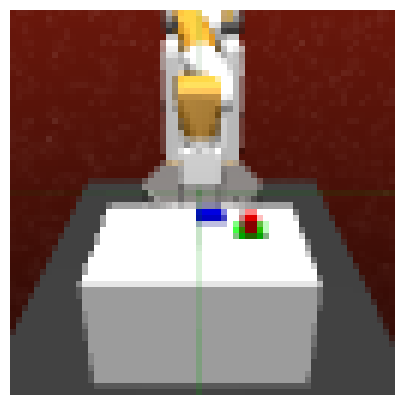

In [16]:
# Visualisations of the front view images
# down & left = directions of increase
i = 0
for image in front_images[:200]:
    i += 1
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis('off')  # Turn off the axis
    plt.pause(0.001)  # Pause for 1 second between images
    # clear the current image
    clear_output(wait=True)

Get Corresponding Labels (Positions + Velocities)

In [17]:
# convert observations to a torch tensor
observations = torch.tensor(observations, dtype=torch.float32).to('cpu')
print(observations.shape)

torch.Size([10000, 6])


/tmp/ipykernel_1036/537354801.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  observations = torch.tensor(observations, dtype=torch.float32).to('cpu')


Re-format data into batches of 5

In [18]:
# reformat image and label data
training_images = torch.zeros(int(observations.shape[0]/5), dims, dims, 3*5)
position_labels = torch.zeros(int(observations.shape[0]/5), observations.shape[1])
velocity_labels = torch.zeros(int(observations.shape[0]/5), observations.shape[1])

# reformat data into stacks of 5 images
for i in range(int(observations.shape[0]/5)):
    # stack the 3 RGB channels of every 5 images together
    training_images[i] = torch.cat([front_images[i*5], front_images[i*5+1], front_images[i*5+2], front_images[i*5+3], front_images[i*5+4]], dim=2)
    
    # get the x & y positions for every 5th image
    position_labels[i] = observations[i*5+4]
    
    # get the x & y velocities between every 4th and 5th images
    velocity_labels[i] = observations[i*5+4] - observations[i*5]
    
# reshape traning_images to (n_samples, 3*5, 32, 32)
training_images = training_images.permute(0, 3, 1, 2)

print(training_images.shape)
print(position_labels.shape)
print(velocity_labels.shape)

torch.Size([2000, 15, 64, 64])
torch.Size([2000, 6])
torch.Size([2000, 6])


In [26]:
np.round(velocity_labels[:100], 3)

tensor([[ 0.0150, -0.0050,  0.0000,  0.0300, -0.0110,  0.0000],
        [ 0.0130, -0.0090,  0.0000,  0.0260, -0.0180,  0.0000],
        [ 0.0110, -0.0120,  0.0000,  0.0210, -0.0240,  0.0000],
        [ 0.0070, -0.0140,  0.0000,  0.0140, -0.0280,  0.0000],
        [ 0.0030, -0.0160,  0.0000,  0.0070, -0.0310,  0.0000],
        [-0.0000, -0.0160,  0.0000, -0.0010, -0.0320,  0.0000],
        [-0.0040, -0.0150,  0.0000, -0.0090, -0.0310,  0.0000],
        [-0.0080, -0.0140,  0.0000, -0.0160, -0.0280,  0.0000],
        [-0.0110, -0.0110,  0.0000, -0.0220, -0.0230,  0.0000],
        [-0.0140, -0.0080,  0.0000, -0.0270, -0.0160,  0.0000],
        [-0.0150, -0.0050,  0.0000, -0.0310, -0.0090,  0.0000],
        [-0.0160, -0.0010,  0.0000, -0.0320, -0.0010,  0.0000],
        [-0.0160,  0.0030,  0.0000, -0.0310,  0.0070,  0.0000],
        [-0.0140,  0.0070,  0.0000, -0.0290,  0.0140,  0.0000],
        [-0.0120,  0.0100,  0.0000, -0.0240,  0.0210,  0.0000],
        [-0.0090,  0.0130,  0.0000, -0.0

In [20]:
position_labels[:100]

tensor([[1.3449, 0.7120, 0.4000, 1.3213, 0.9755, 0.4000],
        [1.3616, 0.7011, 0.4000, 1.3548, 0.9538, 0.4000],
        [1.3751, 0.6865, 0.4000, 1.3818, 0.9245, 0.4000],
        [1.3846, 0.6689, 0.4000, 1.4008, 0.8894, 0.4000],
        [1.3895, 0.6496, 0.4000, 1.4105, 0.8507, 0.4000],
        [1.3894, 0.6296, 0.4000, 1.4104, 0.8108, 0.4000],
        [1.3844, 0.6103, 0.4000, 1.4003, 0.7722, 0.4000],
        [1.3747, 0.5928, 0.4000, 1.3811, 0.7372, 0.4000],
        [1.3611, 0.5783, 0.4000, 1.3537, 0.7082, 0.4000],
        [1.3443, 0.5676, 0.4000, 1.3201, 0.6868, 0.4000],
        [1.3253, 0.5614, 0.4000, 1.2822, 0.6743, 0.4000],
        [1.3054, 0.5601, 0.4000, 1.2424, 0.6717, 0.4000],
        [1.2858, 0.5637, 0.4000, 1.2031, 0.6790, 0.4000],
        [1.2677, 0.5721, 0.4000, 1.1669, 0.6957, 0.4000],
        [1.2522, 0.5847, 0.4000, 1.1360, 0.7209, 0.4000],
        [1.2403, 0.6007, 0.4000, 1.1122, 0.7530, 0.4000],
        [1.2328, 0.6192, 0.4000, 1.0972, 0.7899, 0.4000],
        [1.230

In [27]:
# save the training data
torch.save(training_images, 'training_images.pt')
torch.save(position_labels, 'position_labels.pt')
torch.save(velocity_labels, 'velocity_labels.pt')